<a href="https://colab.research.google.com/github/mammadov-tural/amazon_bestsellers/blob/main/Workout_10_Amazon_Bestsellers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. File import**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bestsellers_with_categories.csv to bestsellers_with_categories.csv


# **2. General information about the dataset**

In [ ]:
# import libraries
import pandas as pd
import io

# Read the uploaded file into a DataFrame
bestsellers = pd.read_csv(io.BytesIO(uploaded['bestsellers_with_categories.csv']))


# Display the first 5 lines of the bestsellers
bestsellers.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


In [ ]:
# Let's see info about our dataset
bestsellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         550 non-null    object 
 1   Author       550 non-null    object 
 2   User Rating  550 non-null    float64
 3   Reviews      550 non-null    int64  
 4   Price        550 non-null    int64  
 5   Year         550 non-null    int64  
 6   Genre        550 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 30.2+ KB


# **3. Missing data**

In [ ]:
# Check for missing data
bestsellers.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

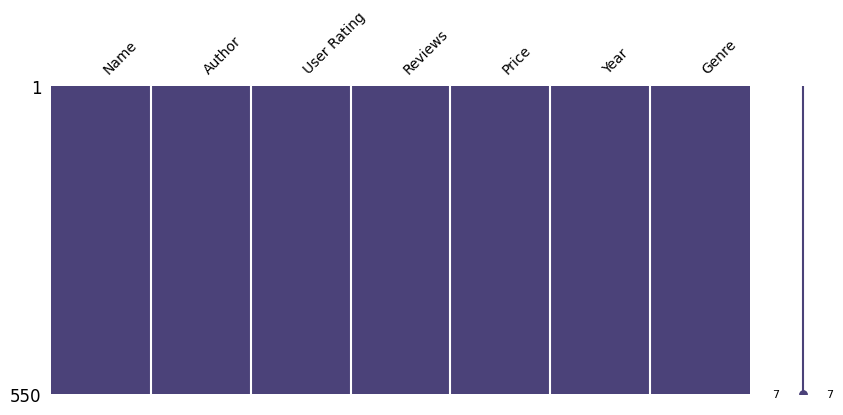

In [ ]:
# Double-check for missing data by visualizing missing values.
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Set color for non-missing data
color = mcolors.hex2color('#4b4279')  # The first color from viridis

# Build a matrix of missing values
msno.matrix(bestsellers, fontsize=10, figsize=(10, 4), color=color)
plt.show()

**As it is seen, the data has no missing values**

# **4. Spelling errors and duplicates**

**Install the fuzzywuzzy library. This is a Python package that uses Levenshtein Distance to measure the similarity between two strings.**

In [ ]:
pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Install an optional Python C extension for a speedup. This is beneficial when working with large datasets as it allows fuzzywuzzy to run faster.**

In [ ]:
pip install fuzzywuzzy[speedup]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 15.2 MB/s eta 0:00:00


In [ ]:
# If there are spelling mistakes in the titles of books or authors, then they are similar to each other and have slight differences in spelling. Let's find them and fix their mistakes.
# Import the 'fuzz' and 'process' modules from the fuzzywuzzy library
from fuzzywuzzy import fuzz, process

# Set threshold for matching
threshold = 90

# Prepare list to store duplicates
duplicates = []

for c in ['Name', 'Author']:
    unique_values = bestsellers[c].unique()
    for i, v in enumerate(unique_values):
        # Find potential matches
        matches = process.extract(v, unique_values, limit=2, scorer=fuzz.token_set_ratio)
        for match, score in matches:
            if match != v and score >= threshold and {v, match} not in duplicates:
                duplicates.append((v, match, score))

# Convert duplicates list into a pandas DataFrame
duplicates_bestsellers = pd.DataFrame(duplicates, columns=['Value 1', 'Value 2', 'Score'])

# Show DataFrame
duplicates_bestsellers

,Value 1,Value 2,Score
0,12 Rules for Life: An Antidote to Chaos,Life,100
1,A Stolen Life: A Memoir,Life,100
2,Becoming,The 4 Hour Body: An Uncommon Guide to Rapid Fa...,100
3,"Breaking Dawn (The Twilight Saga, Book 4)","Twilight (The Twilight Saga, Book 1)",96
4,Catching Fire (The Hunger Games),The Hunger Games,100
...,...,...,...
60,You Are a Badass: How to Stop Doubting Your Gr...,Life,100
61,George R. R. Martin,George R.R. Martin,100
62,J.K. Rowling,J. K. Rowling,100
63,George R.R. Martin,George R. R. Martin,100


**After carefully checking the above table, the following mistakes are found:**

* 'J. K. Rowling' will be replaced with: 'J.K. Rowling',
* 'George R. R. Martin' will be replaced with: 'George R.R. Martin',
* 'The Hunger Games' will be replaced with: 'The Hunger Games (Book 1)',
* 'Eclipse (Twilight)' will be replaced with: 'Eclipse (Twilight Sagas)',
* 'The Girl Who Played with Fire (Millennium)' will be replaced with: 'The Girl Who Played with Fire (Millennium Series)'

We need to change these names because the correct ones are already in our data. If left uncorrected, these errors could result in the same book being counted as distinct entries.

In [ ]:
# Replace values with correct ones
replace_values = {
    'George R. R. Martin': 'George R.R. Martin',
    'J. K. Rowling': 'J.K. Rowling',
    'The Hunger Games': 'The Hunger Games (Book 1)',
    'Eclipse (Twilight)': 'Eclipse (Twilight Sagas)',
    'The Girl Who Played with Fire (Millennium)': 'The Girl Who Played with Fire (Millennium Series)',
}

duplicates_bestsellers = duplicates_bestsellers.replace(replace_values)

# Apply the changes to the original data
bestsellers = bestsellers.replace(replace_values)
bestsellers

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction
...,...,...,...,...,...,...,...
545,Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,2019,Fiction
546,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2016,Non Fiction
547,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2017,Non Fiction
548,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2018,Non Fiction


# **5. Top 10 authors by rating**

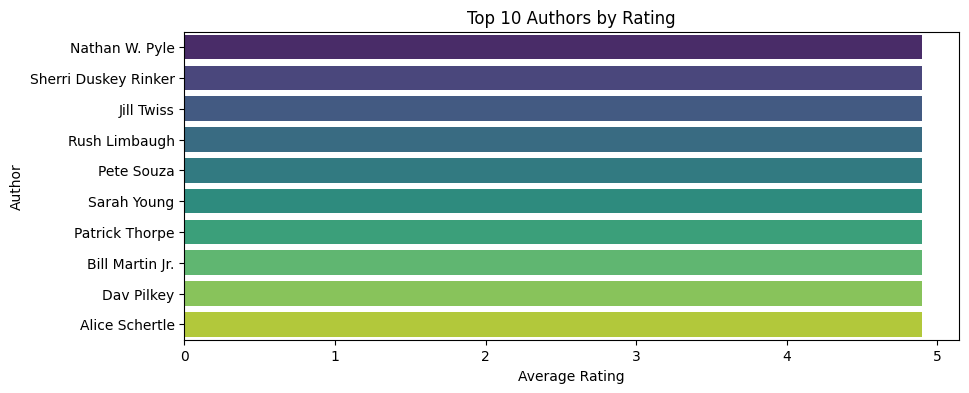

In [ ]:
# Import only seaborn. Matplotlib has already imported above  
import seaborn as sns

# Group the dataset by 'Author', calculate the mean 'User Rating' for each author, sort them in descending order, and select the top 10 authors
top_authors = bestsellers.groupby('Author')['User Rating'].mean().sort_values(ascending=False).head(10)

# Plot the result
plt.figure(figsize=(10, 4))
sns.barplot(x=top_authors.values, y=top_authors.index, palette='viridis')
plt.title('Top 10 Authors by Rating')
plt.xlabel('Average Rating')
plt.show()

# **6. Distribution of book genre**

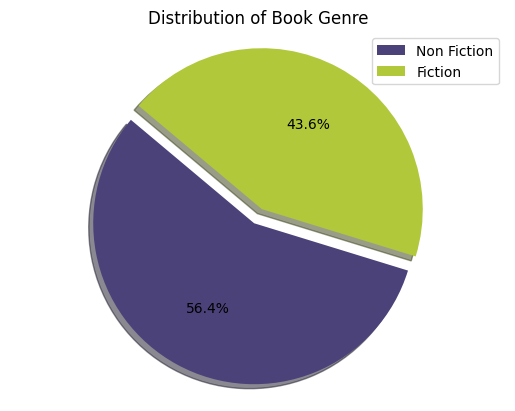

In [ ]:
# Define a list of color codes
colors = ['#4b4279', '#b2c83b']

# Define explode parameters
explode = (0.1, 0) 

# Plot the pie chart without labels on the slices
genre_counts = bestsellers['Genre'].value_counts()
plt.pie(genre_counts, explode=explode, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)

plt.title('Distribution of Book Genre')
plt.legend(labels=genre_counts.index, loc='upper right')
plt.axis('equal')
plt.show()

# **7. Top 5 books by number of reviews**

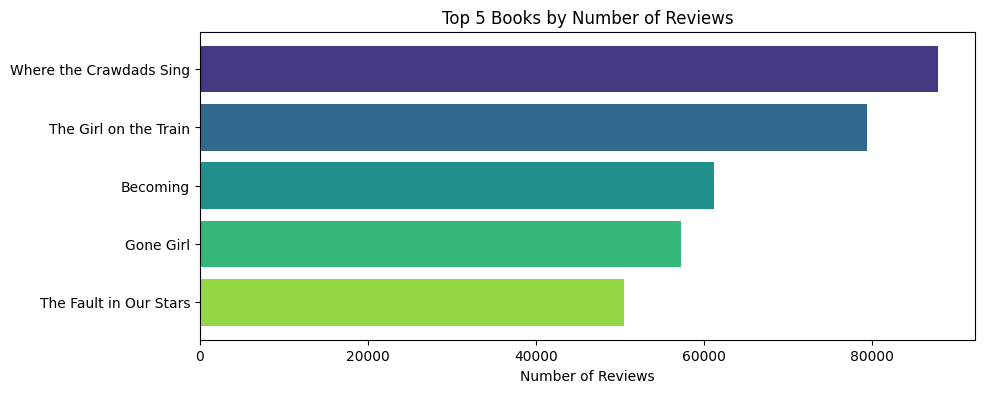

In [ ]:
# Define number of colors needed
num_colors = 5

# Create a color palette
color_palette = sns.color_palette('viridis_r', num_colors)

# Convert color palette to list of RGB values
colors = color_palette.as_hex()

# Create a temporary DataFrame with duplicates dropped
df_temp = bestsellers.drop_duplicates(subset='Name')

# Plot top 5 books by number of reviews
top_books = df_temp.sort_values('Reviews', ascending=False).head(5)
top_books = top_books.iloc[::-1]  # reverse the order of the rows

# Plot the result
plt.figure(figsize=(10, 4))
plt.barh(top_books['Name'], top_books['Reviews'], color=colors)
plt.title('Top 5 Books by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.show()

# **8. Outliers**

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Create subplots: 1 row, 3 columns
fig = make_subplots(rows=1, cols=3)

# Create box plots
box1 = px.box(bestsellers, x='Reviews', color_discrete_sequence=px.colors.sequential.Viridis)
box2 = px.box(bestsellers, x='User Rating', color_discrete_sequence=px.colors.sequential.Viridis)
box3 = px.box(bestsellers, x='Price', color_discrete_sequence=px.colors.sequential.Viridis)

# Add box plots to subplots
fig.add_trace(go.Box(box1.data[0]), row=1, col=1)
fig.add_trace(go.Box(box2.data[0]), row=1, col=2)
fig.add_trace(go.Box(box3.data[0]), row=1, col=3)

# Add title to each subplot
fig.update_xaxes(title_text="Reviews", row=1, col=1)
fig.update_xaxes(title_text="User Rating", row=1, col=2)
fig.update_xaxes(title_text="Price", row=1, col=3)

# Show plot
fig.show()

The "dots" in a box plot represent outliers in the data. An outlier is a data point that is significantly different from other similar points. They are unusual observations that lie far away from the majority of observations.

* In the "Reviews" and "Price" box plots, the outliers (dots) are on the right side because these represent books that have significantly more reviews or a higher price than the majority of books. These are unusually popular or expensive books.

* In contrast, in the "User Rating" box plot, the outliers (dots) are on the left side because these represent books with significantly lower ratings than the majority of books. These are unusually poorly rated books.

# **9. Popularity of Genres Over the Years**

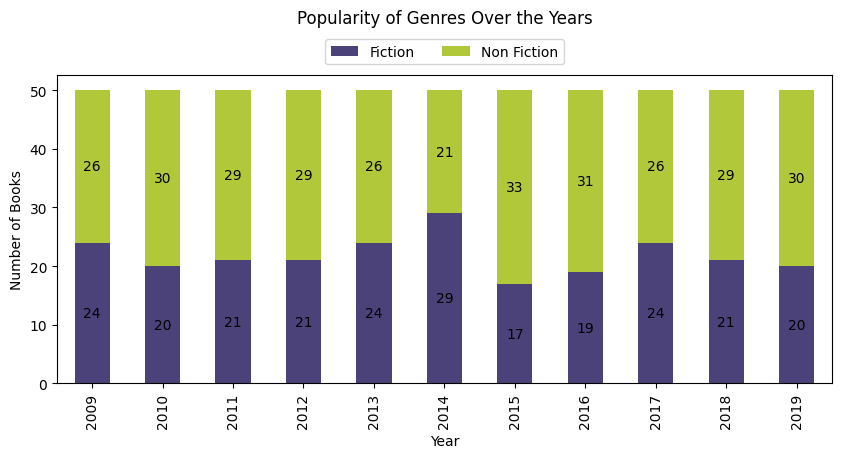

In [ ]:
# Group by 'Year' and 'Genre' and count the number of books
genre_popularity = bestsellers.groupby(['Year', 'Genre']).size().unstack()

# Define a list of color codes
colors = ['#4b4279', '#b2c83b']

# Plot the result
ax = genre_popularity.plot(kind='bar', stacked=True, color=colors, figsize=(10, 4))
plt.title('Popularity of Genres Over the Years', y=1.08, pad=20)
plt.xlabel('Year')
plt.ylabel('Number of Books')

# Add annotation on each bar
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

# Move the legend to the upper center with some distance from the data series and arrange the legend entries in one line
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.14), ncol=2)

plt.show()

# **10. User Rating Distribution by Genre**

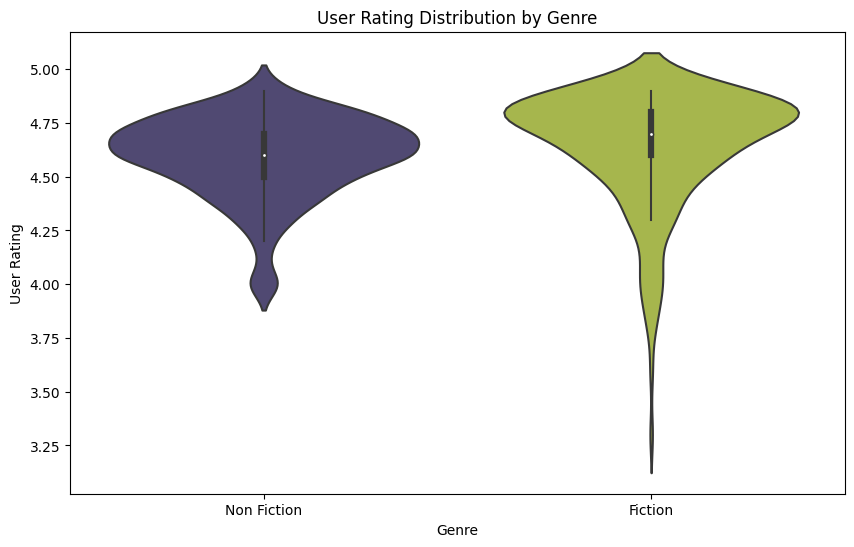

In [ ]:
# Define color palette
colors = ['#4b4279', '#b2c83b']

# Create a Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Genre', y='User Rating', data=bestsellers, palette=colors)
plt.title('User Rating Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('User Rating')
plt.show()

The violin plot is a combination of a box plot and a kernel density plot. It illustrates the distribution and probability density of the data.

* The wider sections of the violin plot represent a higher probability that members of the population will take on the given value; 
* The skinnier sections represent a lower probability.

# **11. Average Book Price Over the Years by Genre**

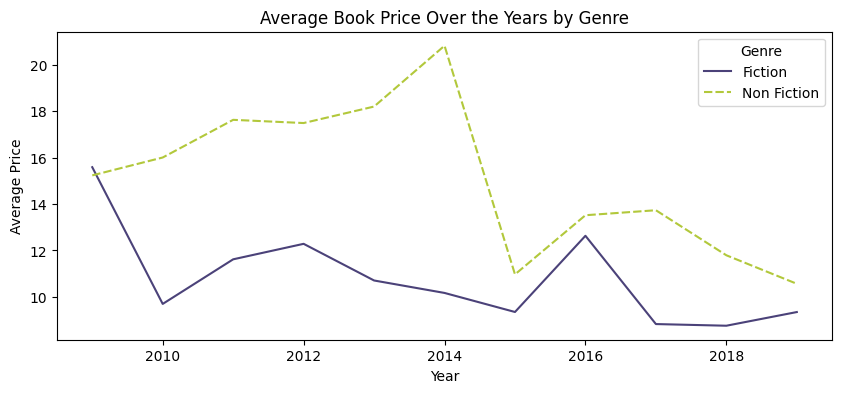

In [ ]:
# Define the color palette
colors = ['#4b4279', '#b2c83b']

# Group by 'Year' and 'Genre' and calculate average 'Price'
average_price_by_year_genre = bestsellers.groupby(['Year', 'Genre'])['Price'].mean().unstack()

# Plot the result
plt.figure(figsize=(10, 4))
sns.lineplot(data=average_price_by_year_genre, palette=colors)
plt.title('Average Book Price Over the Years by Genre')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.legend(title='Genre')
plt.show()

# **12. Average User Rating Over the Years by Genre**

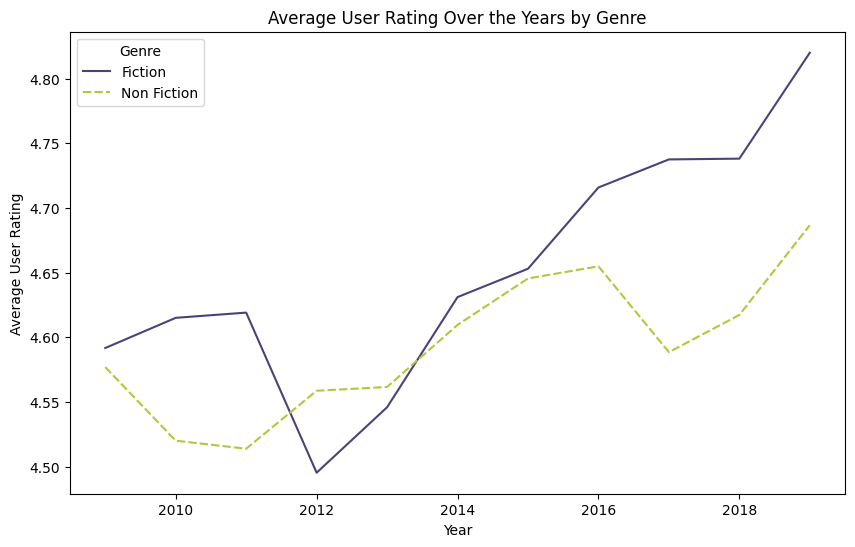

In [ ]:
# Group by 'Year' and 'Genre' and calculate average 'User Rating'
average_rating_by_year_genre = bestsellers.groupby(['Year', 'Genre'])['User Rating'].mean().unstack()

# Plot the result
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_rating_by_year_genre, palette=colors)
plt.title('Average User Rating Over the Years by Genre')
plt.xlabel('Year')
plt.ylabel('Average User Rating')
plt.show()